In [61]:
from bs4 import BeautifulSoup  # requirement beautifulsoup4
from urllib.request import (
    urlopen, urlretrieve)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os, os.path
import sys
import pandas as pd
import numpy as np

data_dir = "./data/lcc_footfall"  # Where to save the csv files
if not os.path.isdir(data_dir):
    print("Creating data directory {}".format(data_dir))
    os.makedirs(data_dir)

# Connect to the Data Mill North page and parse the html
root = 'https://datamillnorth.org/dataset/leeds-city-centre-footfall-data'
soup = BeautifulSoup(urlopen(root), 'html.parser')
legit_copy_suff = ["April%202019.csv",
                   "May%202019.csv",
                   "June%202019.csv",
                   "July%202019.csv",
                   "May%202020.csv"]

# Iterate over all links and see which are csv files
for link in soup.find_all('a'):
    # print("\n****",link,"****\n")
    url = link.get('href')
    if url == None:  # if no 'href' tag
        continue

    if url.endswith(".csv"):
        filename = url.strip().split("/")[-1]  # File is last part of the url

        # For some reason some files are duplicated
        if (filename.startswith("Copy") or filename.startswith("copy")) and not filename.endswith(
                tuple(legit_copy_suff)):
            continue
        # And we don't care about xmas analysis
        if filename.startswith("Christ"):
            continue

        # Save the csv file (unless it already exists already)
        full_path = os.path.join("./data/lcc_footfall", filename)
        if os.path.isfile(full_path):
            print("File {} exists already, not downloading".format(filename))
        else:
            print("Downloading {}".format(filename))
            csv_url = "https://datamillnorth.org/" + url
            data = pd.read_csv(csv_url)
            data.to_csv(full_path)

print("Finished")

File Weekly%20Data%2019.04.21%20-%2025.04.21.csv exists already, not downloading
File Weekly%20Data%2019.04.21%20-%2025.04.21.csv exists already, not downloading
File Weekly%20Data%2019.04.21%20-%2025.04.21.csv exists already, not downloading
File Weekly%20Data%2019.04.21%20-%2025.04.21.csv exists already, not downloading
File Weekly%20Data%2012.04.21%20-%2018.04.21.csv exists already, not downloading
File Weekly%20Data%2012.04.21%20-%2018.04.21.csv exists already, not downloading
File Weekly%20Data%2012.04.21%20-%2018.04.21.csv exists already, not downloading
File Weekly%20Data%2012.04.21%20-%2018.04.21.csv exists already, not downloading
File Weekly%20Data%2005.04.21%20-%2011.04.21.csv exists already, not downloading
File Weekly%20Data%2005.04.21%20-%2011.04.21.csv exists already, not downloading
File Weekly%20Data%2005.04.21%20-%2011.04.21.csv exists already, not downloading
File Weekly%20Data%2005.04.21%20-%2011.04.21.csv exists already, not downloading
File Weekly%20Data%2029.03.2

In [62]:
def convert_hour(series):
    """Assumes the given series represents hours. Works out if they're
    integers or in the format '03:00:00' and returns them as integers"""

    # If it's a number then just return it
    if isinstance(series.values[0], np.int64) or isinstance(series.values[0], np.float64) or isinstance(
            series.values[0], float):
        return series

    # If it's a string see if it can be made into a number
    try:
        int(series.values[0])
        return pd.to_numeric(series)
    except:  # If get here then it couldn't be made into an integer
        pass

    if ":" in series.values[0]:
        return pd.to_numeric(series.apply(lambda x: x.strip().split(":")[0]))

    # If here then I don't know what to do.
    raise Exception("Unrecognised type of hours: {}".format(series))


# Template for our data frame. Set the type as well (default type is OK for 'location' and 'FileName')
template = pd.DataFrame(columns=["Location", "Date", "Hour", "Count", "DateTime", "FileName"])
template["Date"] = pd.to_datetime(template["Date"], dayfirst=True)
template["Hour"] = pd.to_numeric(template["Hour"])
template["Count"] = pd.to_numeric(template["Count"])
template["DateTime"] = pd.to_datetime(template["DateTime"])  # (this one is derived from date and hour)

frames = []  # Build up a load of dataframes then merge them
total_rows = 0  # For checking that the merge works
files = []  # Remember the names of the files we tried to analyse
failures = []  # Remember which ones didn't work

# Read the files in
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        try:
            # print(filename)
            files.append(filename)
            df = pd.read_csv(os.path.join(data_dir, filename))

            # Check the file has the columns that we need, and work out what the column names are for this file (annoyingly it changes)
            date_col = "Date"  # Doesn't change
            count_col = "Count" if "Count" in df.columns else "InCount"  # Two options
            hour_col = "Hour"
            loc_col = "Location" if "Location" in df.columns else "LocationName"

            if False in [date_col in df.columns, count_col in df.columns, hour_col in df.columns,
                         loc_col in df.columns]:
                raise Exception("File '{}' is missing a column. Date? {}, Count? {}, Hour? {}, Location? {}".
                                format(filename, date_col in df.columns, count_col in df.columns,
                                       hour_col in df.columns, loc_col in df.columns))

            # Check if any of the columns have nans
            bad_cols = []
            for x in [date_col, count_col, hour_col, loc_col]:
                if True in df[x].isnull().values:
                    bad_cols.append(x)
            if len(bad_cols) > 0:
                failures.append(filename)
                print(f"File {filename} has nans in the following columns: '{str(bad_cols)}'. Ignoring it")
                continue

            # Create Series' that will represent each column
            dates = pd.to_datetime(df[date_col], dayfirst=True)
            counts = pd.to_numeric(df[count_col])
            hours = convert_hour(df[hour_col])  # Hours can come in different forms
            locs = df[loc_col]

            # Strip whitespace from the locations
            locs = locs.apply(lambda row: row.strip())

            # Derive a proper date from the date and hour
            # (Almost certainly a more efficient way to do this using 'apply' or whatever)
            dt = pd.to_datetime(pd.Series(data=[date.replace(hour=hour) for date, hour in zip(dates, hours)]))

            # Also useful to have the filename
            fnames = [filename for _ in range(len(df))]

            # df.apply(lambda x: x[date_col].replace(hour = x[hour_col]), axis=1)

            if False in [len(df) == len(x) for x in [dates, counts, hours, locs, dt]]:
                raise Exception("One of the dataframe columns does not have enough values")
            total_rows += len(df)

            # Create a temporary dataframe to represent the information in that file.
            # Note that consistent column names (defined above) are used
            frames.append(pd.DataFrame(data=
                                       {"Location": locs, "Date": dates, "Hour": hours,
                                        "Count": counts, "DateTime": dt, "FileName": fnames}))

        except Exception as e:
            print("Caught exception on file {}".format(filename))
            raise e

# Finally megre the frames into one big one
merged_frames = pd.concat(frames)
if total_rows != len(merged_frames):
    raise Exception(f"The number of rows in the individual files {total_rows} does \
not match those in the final dataframe {len(merged_frames)}.")

footfall_data = template.append(merged_frames)

print(
    f"Finished. Made a dataframe with {len(footfall_data)} rows. {len(failures)}/{len(files)} files could not be read.")


File Monthly%20Data%20Feed%20-%20%20Jan%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Dec%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Nov%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-April%202017%20-%2020170510.csv has nans in the following columns: '['Date', 'InCount', 'Hour', 'Location']'. Ignoring it
File Monthly%20Data%20Feed-Feb%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-March%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
Finished. Made a dataframe with 724390 rows. 6/111 files could not be read.


Have a look at head, cols etc

In [63]:
footfall_data.head()

,Location,Date,Hour,Count,DateTime,FileName
0,Albion Street South,2020-08-03,0,3,2020-08-03 00:00:00,03.08.20%20-09.08.20.csv
1,Albion Street South,2020-08-03,1,6,2020-08-03 01:00:00,03.08.20%20-09.08.20.csv
2,Albion Street South,2020-08-03,2,1,2020-08-03 02:00:00,03.08.20%20-09.08.20.csv
3,Albion Street South,2020-08-03,3,30,2020-08-03 03:00:00,03.08.20%20-09.08.20.csv
4,Albion Street South,2020-08-03,4,20,2020-08-03 04:00:00,03.08.20%20-09.08.20.csv


In [64]:
footfall_data.columns

Index(['Location', 'Date', 'Hour', 'Count', 'DateTime', 'FileName'], dtype='object')

Check for missing values

In [65]:
footfall_data.isnull().sum()

Location    0
Date        0
Hour        0
Count       0
DateTime    0
FileName    0
dtype: int64

Create a summary table of locations with the total number of entries per location and total footfall

In [66]:
#Groups footfall data by location and runs two functions on Count, sum and count to generate summaries.
summary_counts = footfall_data.groupby(['Location'])['Count'].agg(['sum', 'count'])
#Display summary counts
summary_counts

,sum,count
Location,,
Albion Street North,58998097,72526
Albion Street South,95068685,95760
Albion Street at McDonalds,527455,2184
Briggate,136216720,104472
Briggate at McDonalds,57209448,96240
Commercial Street at Barratts,55805192,65232
Commercial Street at Lush,73102274,59208
Commercial Street at Sharps,31601863,37032
Dortmund Square,85912496,94776


Check that there are no duplicates by evaluating whether combinations of location and datetime are unique.

In [67]:
#Groups footfall data by location and datetime, counting the number of occurrences by calling size.
#Also Resets the index to restore the grouped columns and renames the size column to UniqueRowsCount
unq_loc_datetime = footfall_data.groupby(
    ['Location', 'DateTime']).size().reset_index().rename(columns={0: 'UniqueRowsCount'})
unq_loc_datetime

#Check to see if there are any values in the UniqueRowsCount column greater than one (indicating there are duplicate rows)
if len(unq_loc_datetime[unq_loc_datetime.UniqueRowsCount > 1]) > 1:
    #Print how many duplicate combinations there are then print a summary of the records
    print(
        f"Footfall dataframe contains {len(unq_loc_datetime[unq_loc_datetime.UniqueRowsCount > 1])} duplicate location/datetime combinations")
    print(unq_loc_datetime[unq_loc_datetime.UniqueRowsCount > 1])

del unq_loc_datetime

Footfall dataframe contains 6768 duplicate location/datetime combinations
                   Location            DateTime  UniqueRowsCount
138214  Albion Street South 2017-06-01 00:00:00                2
138215  Albion Street South 2017-06-01 01:00:00                2
138216  Albion Street South 2017-06-01 02:00:00                2
138217  Albion Street South 2017-06-01 03:00:00                2
138218  Albion Street South 2017-06-01 04:00:00                2
...                     ...                 ...              ...
694673              Headrow 2018-12-12 19:00:00                2
694674              Headrow 2018-12-12 20:00:00                2
694675              Headrow 2018-12-12 21:00:00                2
694676              Headrow 2018-12-12 22:00:00                2
694677              Headrow 2018-12-12 23:00:00                2

[6768 rows x 3 columns]


As this data cleaning process is adapted from Nick Malleson's exploration of the footfall data, I'll bypass investigating why there are duplicates as he's already done this.  Safe to say that the numbers we both found are identical and seem to be due to errors in the csv files rather than code.  There doesn't appear to be anything new since introducing more recent data files so I'll remove the duplicates and carry on cleaning.

In [68]:
#Drop duplicates from dataframe
ffd_no_dup = footfall_data.drop_duplicates()
#Rerun duplicate check
unq_loc_datetime = ffd_no_dup.groupby(
    ['Location', 'DateTime']).size().reset_index().rename(columns={0: 'UniqueRowsCount'})
print(f"There are {len(unq_loc_datetime[unq_loc_datetime.UniqueRowsCount > 1])} duplicates left")

ffdf = ffd_no_dup

ffdf.head()

del unq_loc_datetime, ffd_no_dup

There are 0 duplicates left


Nick also combined the cameras at Commercial Street Lush and Commercial Street Sharps as he found that they'd moved.  The process to do so is below:

In [69]:
#First calculate the total footfall of the two cameras combined

cameras_to_combine = ffdf.loc[ffdf.Location.isin(["Commercial Street at Lush",
                                                  "Commercial Street at Sharps"])]

total_when_seperate = sum(cameras_to_combine['Count'])
print(total_when_seperate)

ffdf = ffdf.replace({'Location': {'Commercial Street at Lush': 'Commercial Street Combined',
                                  'Commercial Street at Sharps': 'Commercial Street Combined'}})

ffdf.loc[ffdf.Location == "Commercial Street Combined"]

# Check the total footfall in those two Commercial Street locations hasn't changed
total_combined = sum(ffdf.loc[ffdf.Location == "Commercial Street Combined", "Count"])

if total_when_seperate == total_combined:
    print("Footfall hasn't changed")
else:
    print("Footfall has changed")

#Uses an f-string (Literal String Interpolation) to print out the differences in footfall if any.
print(f"Total footfall when seperate {total_when_seperate}\nTotal when combined {total_combined}")

ffdf.groupby(['Location'])['Count'].agg(['sum', 'count'])

del cameras_to_combine, total_combined, total_when_seperate

103489491
Footfall hasn't changed
Total footfall when seperate 103489491
Total when combined 103489491


Remove any entries that occurred before 2008-08-27 as this is the latest that any camera comes online.

In [70]:
ffdf = ffdf.loc[ffdf.DateTime >= '2008-08-27']

ffdf.groupby(['Location'])['Count'].agg(['sum', 'count'])

,sum,count
Location,,
Albion Street North,58755468,72262
Albion Street South,93210868,93768
Albion Street at McDonalds,527455,2184
Briggate,120125290,93768
Briggate at McDonalds,55558439,93768
Commercial Street Combined,100767232,93768
Commercial Street at Barratts,55805192,65232
Dortmund Square,84937489,93768
Headrow,57746768,93768


In [71]:
#Aggregate all locations into a grouped dataframe and set the index to DateTime.  Show count as the only values column.
ffdf_grouped = ffdf.groupby(['DateTime'])['Count'].sum().reset_index().set_index('DateTime')

grouped_days = ffdf_grouped.resample('D').sum()
print(f"{len(grouped_days.loc[grouped_days.Count == 0, 'Count'])} days have no footfall")
grouped_weeks = ffdf_grouped.resample('W').sum()
print(f"{len(grouped_weeks.loc[grouped_weeks.Count == 0, 'Count'])} weeks have no footfall")
grouped_months = ffdf_grouped.resample('M').sum()
print(f"{len(grouped_months.loc[grouped_months.Count == 0, 'Count'])} months have no footfall")

print(f"{grouped_months.loc[grouped_months.Count == 0, 'Count']}")

del grouped_days, grouped_months, grouped_weeks, ffdf_grouped

718 days have no footfall
99 weeks have no footfall
21 months have no footfall
DateTime
2015-03-31    0
2015-12-31    0
2016-02-29    0
2016-03-31    0
2016-06-30    0
2016-07-31    0
2016-08-31    0
2016-11-30    0
2016-12-31    0
2017-01-31    0
2017-02-28    0
2017-03-31    0
2017-04-30    0
2017-09-30    0
2017-10-31    0
2017-11-30    0
2017-12-31    0
2018-01-31    0
2018-02-28    0
2018-03-31    0
2018-10-31    0
Name: Count, dtype: int64


Investigate how many days have hours missing.

In [72]:
#Use a pd.grouper to allow further grouping by DateTime, avoiding having to set the index after grouping by Location
hours_missing = ffdf.groupby(['Location', pd.Grouper(key='DateTime',
                                                     freq='D')]).count().reset_index()  # including reset_index here basically ensures every entry has the relevant Location value and a unique index that can be accessed.
hours_missing.loc[hours_missing.Date < 24]

del hours_missing

There aren't many days with hours missing so these can be left in.

In [73]:
grouped_months = ffdf.resample('M', on='DateTime').sum().reset_index()
zero_days = grouped_months.loc[grouped_months.Count < 1, ["DateTime", "Count"]]
zero_days

# for date in zero_days['DateTime']:
#     print(date)
#     print(ffdf.loc[(ffdf.DateTime >= date.replace(hour=0)) & (ffdf.DateTime <= date.replace(hour=23)), :])

,DateTime,Count
79,2015-03-31,0
88,2015-12-31,0
90,2016-02-29,0
91,2016-03-31,0
94,2016-06-30,0
95,2016-07-31,0
96,2016-08-31,0
99,2016-11-30,0
100,2016-12-31,0
101,2017-01-31,0


In [74]:
#Create weekday numbers and names, plus months and years.
# ffdf['weekday'] = ffdf['DateTime'].dt.dayofweek
# ffdf['weekdayname'] = ffdf['DateTime'].dt.day_name()
# ffdf['weekno'] = ffdf['DateTime'].dt.isocalendar().week
# ffdf['month'] = ffdf['DateTime'].dt.month
# ffdf['year'] = ffdf['DateTime'].dt.year
# ffdf

Output to CSV file for analysis elsewhere

In [75]:
ffdf.to_csv("./data/lcc_footfall_combined.csv")


In [76]:
dataMS = ffdf.set_index('DateTime').loc['2020'].groupby(
    [pd.Grouper(level="DateTime",
                freq="MS")]).aggregate(np.mean)

dataM = ffdf.set_index('DateTime').loc['2020'].groupby(
    [pd.Grouper(level="DateTime",
                freq="M")]).aggregate(np.mean)

print(dataM, dataMS)

            Hour       Count
DateTime                    
2020-01-31  11.5  806.301971
2020-02-29  11.5  808.128352
2020-03-31  11.5  531.911514
2020-04-30  11.5   91.059722
2020-05-31  11.5  109.035618
2020-06-30  11.5  253.799537
2020-07-31  11.5  457.924283
2020-08-31  11.5  579.253808
2020-09-30  11.5  465.167917
2020-10-31  11.5  411.943710
2020-11-30  11.5  275.595602
2020-12-31  11.5  580.602823             Hour       Count
DateTime                    
2020-01-01  11.5  806.301971
2020-02-01  11.5  808.128352
2020-03-01  11.5  531.911514
2020-04-01  11.5   91.059722
2020-05-01  11.5  109.035618
2020-06-01  11.5  253.799537
2020-07-01  11.5  457.924283
2020-08-01  11.5  579.253808
2020-09-01  11.5  465.167917
2020-10-01  11.5  411.943710
2020-11-01  11.5  275.595602
2020-12-01  11.5  580.602823


Created a function that creates a summary of total footfall and the mean of all instances of a time interval
(ie. all weekdays in camera history).

In [77]:
#Initialise a dictionary mapping the intervals, date format codes and resampling frequencies for us in functions and loops.
time_intervals = {
    "interval": ["hours", "day", "week", "month", "year"],
    "code": ["%H", "%a", "%W", "%b", "%y"],
    "freq": ["H", "D", "W", "MS", "Y"]
}

#function to create summary dataframes containing total footfall and mean of all footfall.
def create_sum_df(data,time_dico):
    df_dico = {}
    for i,time in enumerate(time_dico['interval'][1:]):
        data_resampled = data.set_index('DateTime').resample(time_dico['freq'][i]).sum()
        if time == 'day':
            data_resampled['weekday'] = data_resampled.index.dayofweek
            data_resampled['weekdayname'] = data_resampled.index.day_name()
            data_resampled = data_resampled.groupby(['weekday','weekdayname'])['Count'].agg(['sum','mean']).reset_index()
        elif time == 'week':
            data_resampled['weekno'] = data_resampled.index.isocalendar().week
            data_resampled = data_resampled.groupby(['weekno'])['Count'].agg(['sum','mean'])
        elif time == 'month':
            data_resampled['month'] = data_resampled.index.month
            data_resampled = data_resampled.groupby(['month'])['Count'].agg(['sum','mean'])
        elif time == 'year':
            data_resampled['year'] = data_resampled.index.year
            data_resampled = data_resampled.groupby(['year'])['Count'].sum()

        df_dico[time] = data_resampled
    return df_dico

df = create_sum_df(ffdf,time_intervals)['day']
df


,weekday,weekdayname,sum,mean
0,0,Monday,82998956,5239.833081
1,1,Tuesday,85806660,5417.087121
2,2,Wednesday,86595926,5458.643848
3,3,Thursday,90788054,5722.898008
4,4,Friday,97117640,6121.888553
5,5,Saturday,123688038,7796.774962
6,6,Sunday,60763229,3830.259014


The following are a series of bar charts showing the mean of total footfall counts across a series of categories.

The first is mean footfall of all weekdays since the cutoff date of 27/08/2008 used as the starting point earlier.

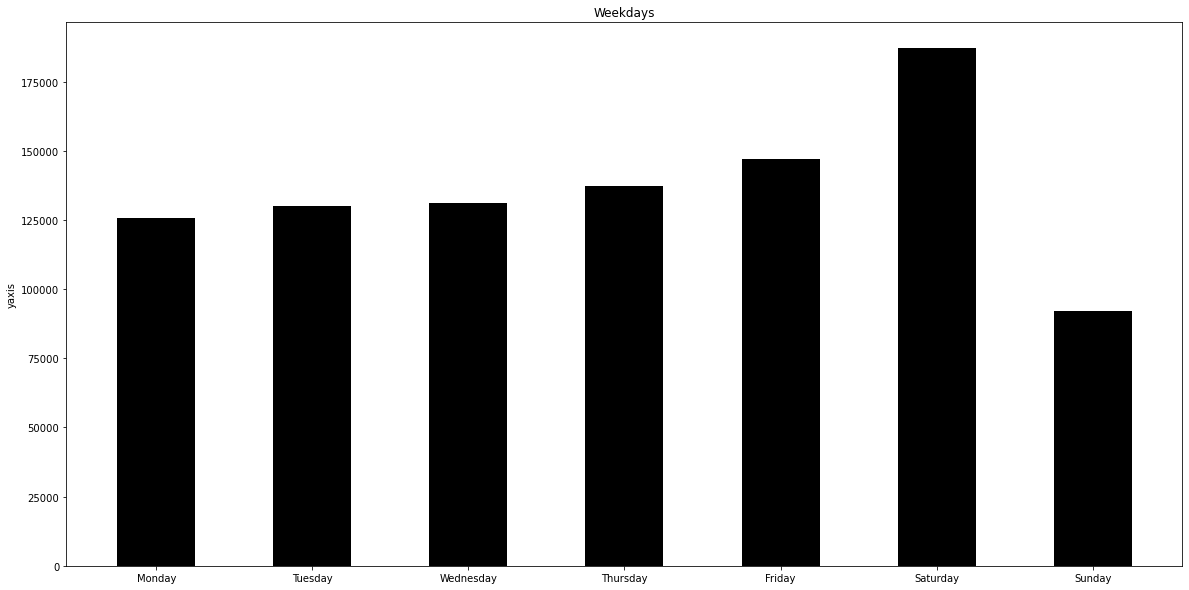

In [78]:
days = ffdf.copy()
days = days.set_index('DateTime').resample('D').sum()
days['weekday'] = days.index.day_of_week
days['weekdayname'] = days.index.day_name()
days = days.groupby(['weekday','weekdayname'])['Count'].agg(['sum','mean']).reset_index()
days

fig, ax = plt.subplots(1,1, figsize=(20, 10))

ax.bar(days.weekdayname, days['mean'], color="black", width=0.5)
ax.set(title='Weekdays')
ax.set_xticks(days.weekdayname)
ax.set_ylabel("yaxis")
plt.show()




Followed by mean of all months since 28/08/2008

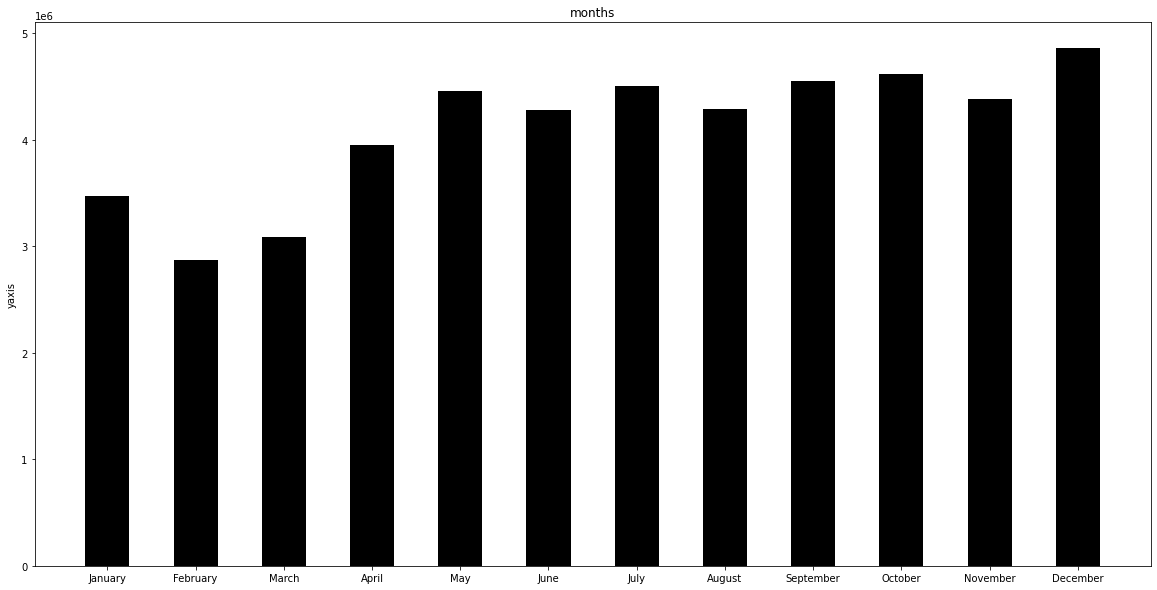

In [79]:
months = ffdf.copy()
months = months.set_index('DateTime').resample('MS').sum()
months['month'] = months.index.month
months['monthname'] = months.index.month_name()
months = months.groupby(['month','monthname'])['Count'].agg(['sum','mean']).reset_index()
months

fig, ax = plt.subplots(1,1, figsize=(20, 10))

ax.bar(months.monthname, months['mean'], color="black", width=0.5)
ax.set(title='months')
ax.set_xticks(months.monthname)
ax.set_ylabel("yaxis")
plt.show()

Followed by total of all years since 28/08/2008.

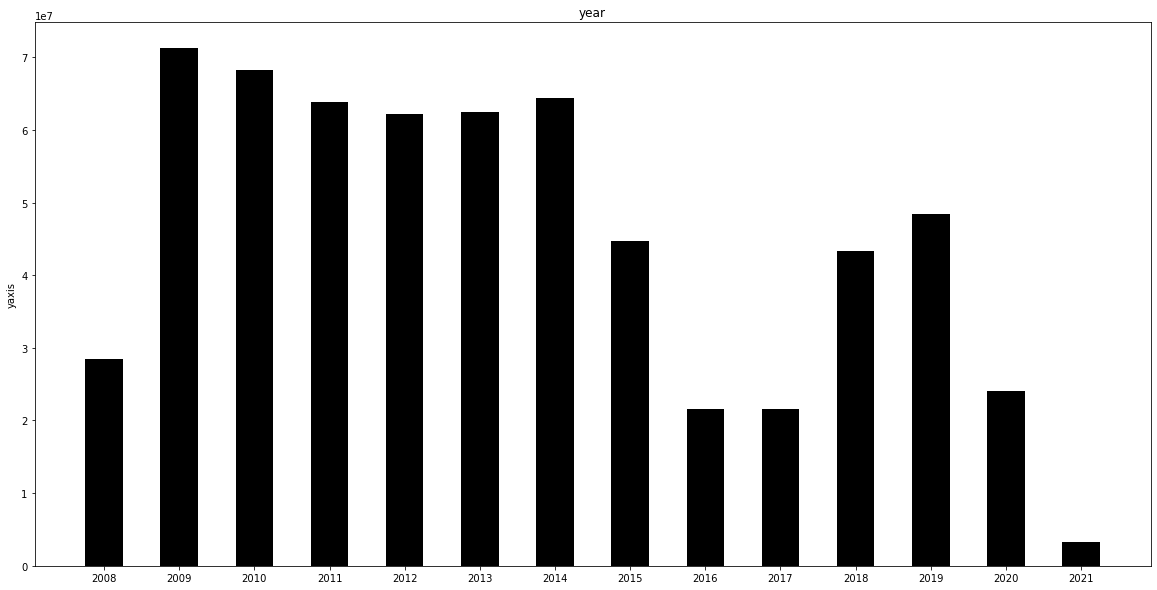

In [80]:
years = ffdf.copy()
years = years.set_index('DateTime').resample('Y').sum()
years['year'] = years.index.year
years = years.groupby(['year'])['Count'].sum().reset_index()
years

fig, ax = plt.subplots(1,1, figsize=(20, 10))

ax.bar(years.year, years['Count'], color="black", width=0.5)
ax.set(title='year')
ax.set_xticks(years.year)
ax.set_ylabel("yaxis")
plt.show()

Initially tried to build charts above in a loop but couldn't get it to work, after experimenting individually I realised
that it was because I was trying to apply date formatters and locators to non-datetime fields.
Will fix the loop below so breakdown of time periods can be dynamically generated and expanded with less code.

In [81]:
# time_intervals = {
#     "interval": ["hours", "day", "month", "year"],
#     "code": ["%H", "%a", "%b", "%y"],
#     "freq": ["H", "D", "MS", "Y"],
#     "locator" :[mdates.HourLocator,
#                  mdates.WeekdayLocator,
#                  mdates.MonthLocator,
#                  mdates.YearLocator]
# }
#
# fig, axes = plt.subplots(1, 3, figsize=(20, 10))
#
# for i, (ax, time) in enumerate(zip(axes.flatten(), time_intervals['interval'][1:])):
#     #Construct data frame by filtering on year and grouping by month.
#     data = create_sum_df(ffdf,time_intervals)[time]
#     if time != 'year':
#         ax.bar(data.index, data['mean'], color="black", width=10)
#     else:
#         ax.bar(data.index, data, color="black", width=10)
#     ax.set(title=time)
#     date_form = DateFormatter(time_intervals['code'][i])
#     ax.xaxis.set_major_formatter(date_form)
#     date_locator = time_intervals['locator'][i]()
#     ax.xaxis.set_major_locator(date_locator)
#     ax.set_ylabel("yaxis")
# #for i,(ax,time) in  enumerate(zip(axes.flatten(), time_intervals.keys())):
# #ax.set_ylim(max_ylim)

plt.show()

The bar charts below show mean hourly footfall over each month for 2018-2021.  This has helped to identify gaps in
the data so creating a more complete file.  It's also really interesting to see the immediate impacts lockdown had on
footfall, even in late March when restrictions were only implemented in the very last week of the month.

Would be good to quantify just how much footfall has fallen compared to the same months in previous years,
also to see how much it fell compared to changes between months across the years.

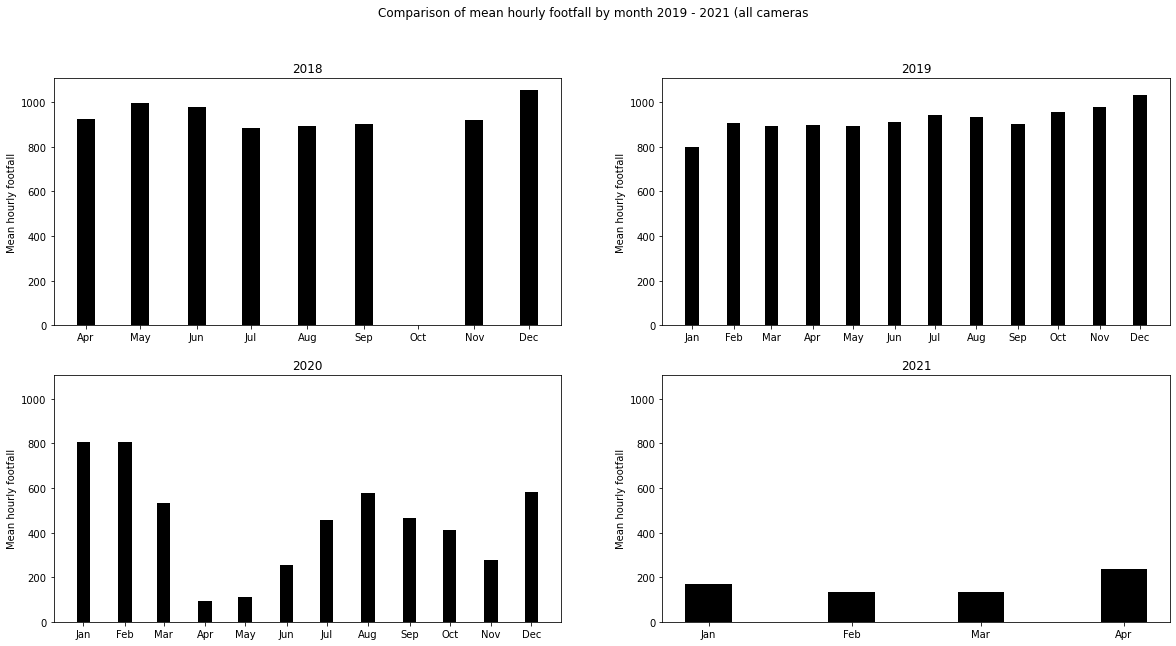

In [82]:
years_list = ['2018', '2019', '2020', '2021']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Comparison of mean hourly footfall by month 2019 - 2021 (all cameras")

for i, (ax, year) in enumerate(zip(axes.flatten(), years_list)):
    #Construct data frame by filtering on year and grouping by month.
    data = ffdf.set_index('DateTime').loc[year].groupby(
        [pd.Grouper(level="DateTime",
                    freq="MS")]).aggregate(np.mean)

    ax.bar(data.index, data.Count, color="black", width=10)
    ax.set(title=year)
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_ylabel("Mean hourly footfall")
    if i == 0:
        max_ylim = ax.get_ylim()
    elif ax.get_ylim()[1] > max_ylim[1]:
        max_ylim = ax.get_ylim

for i, (ax, year) in enumerate(zip(axes.flatten(), years_list)):
    ax.set_ylim(max_ylim)

plt.show()